CNN Histopathologic Cancer Detection

Objective

In this mini-project, we aim to develop a Convolutional Neural Network (CNN) model to classify histopathologic image patches as either tumor-positive or tumor-negative. The dataset, derived from the PatchCamelyon (PCam) benchmark and hosted on Kaggle, consists of high-resolution pathology images labeled based on the presence of metastatic tissue in the central 32×32 pixel region.

Dataset Overview:

Images: ~277,000 .tif files (96×96 px RGB)

Train: ~220,000 images with labels (train_labels.csv)

Test: ~57,000 unlabeled images for Kaggle submission

Labels: Binary

1: Tumor present in center

0: No tumor in center

Format: .tif images with corresponding id strings

The dataset is class-imbalanced, with a significantly higher number of non-tumor samples.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
#Exploratory Analyses
import matplotlib.pyplot as plt
from PIL import Image

def inspect_image_dimensions(directory):
    """
    Load the first image in the specified directory and return its shape.
    
    :param directory: Path to folder containing image files.
    :return: Tuple (height, width, channels)
    """
    image_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    
    if not image_files:
        return None
    
    img_path = os.path.join(directory, image_files[0])
    with Image.open(img_path) as img:
        width, height = img.size
        channels = len(img.getbands())  # e.g., RGB = 3
        return (height, width, channels)

# Example use
train_image_dir = '/kaggle/input/histopathologic-cancer-detection/train'
img_shape = inspect_image_dimensions(train_image_dir)
print(f"Sample image dimensions: {img_shape}")

Sample image dimensions: (96, 96, 3)


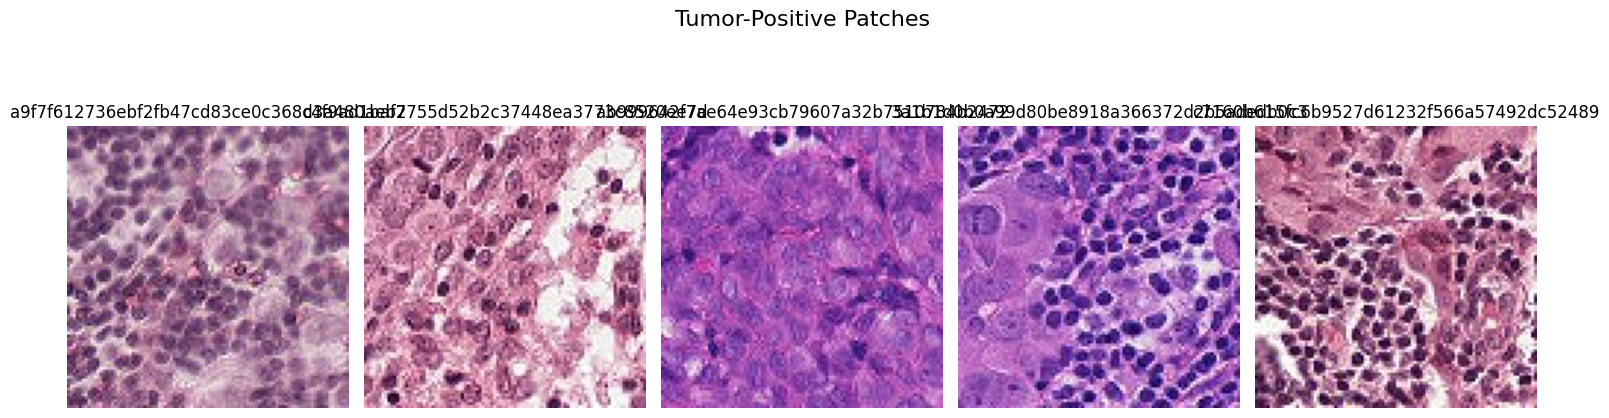

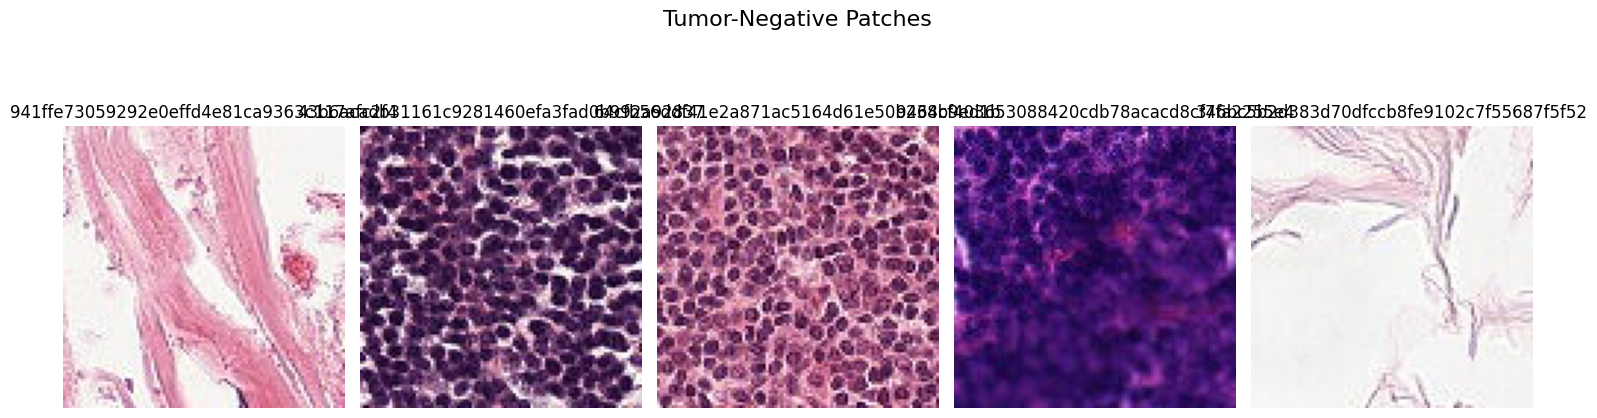

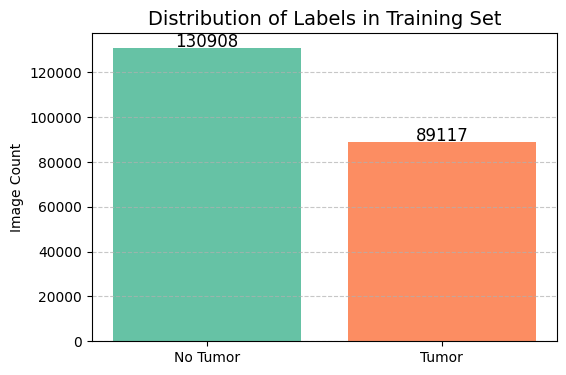

Label 0: 130908 images (59.50%)
Label 1: 89117 images (40.50%)


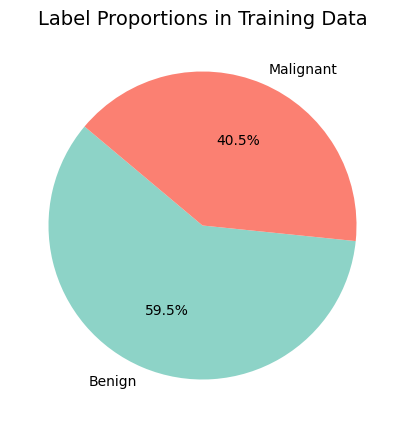

In [23]:
# Load labels
label_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Draw 5 random samples
positive_ids = label_df[label_df['label'] == 1].sample(5, random_state=42)['id'].tolist()
negative_ids = label_df[label_df['label'] == 0].sample(5, random_state=42)['id'].tolist()

# Visual inspection
show_sample_images(positive_ids, label_text="Tumor-Positive Patches")
show_sample_images(negative_ids, label_text="Tumor-Negative Patches")

# Count labels
label_counts = label_df['label'].value_counts()
class_names = ['No Tumor', 'Tumor']

# Plot
plt.figure(figsize=(6, 4))
plt.bar(class_names, label_counts.values, color=['#66c2a5', '#fc8d62'])
plt.title('Distribution of Labels in Training Set', fontsize=14)
plt.ylabel('Image Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontsize=12)
plt.show()

# Print stats
total = label_counts.sum()
for label, count in label_counts.items():
    percent = (count / total) * 100
    print(f"Label {label}: {count} images ({percent:.2f}%)")

#Distribution of Tumor or Not
df_train = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df_test = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

# Convert to readable categories
label_counts = df_train['label'].value_counts().rename({0: 'Benign', 1: 'Malignant'})

# Chart
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=["#8dd3c7", "#fb8072"])
plt.title("Label Proportions in Training Data", fontsize=14)
plt.show()

In [26]:
#Sanity Checks
from PIL import Image
import os

# Define folders
train_folder = '/kaggle/input/histopathologic-cancer-detection/train'
test_folder = '/kaggle/input/histopathologic-cancer-detection/test'

# Define helper
def get_image_shape(folder):
    first_file = next((f for f in os.listdir(folder) if f.endswith('.tif')), None)
    if first_file:
        with Image.open(os.path.join(folder, first_file)) as img:
            return (*img.size[::-1], len(img.getbands()))  # (H, W, C)
    return None

# Run sanity
print("🧪 Data Validation Summary:\n")

print("Training Set")
print(f"✔ All labels are binary (0 or 1):       {set(df_train.label.unique()) <= {0, 1}}")
print(f"✔ Unique training IDs:                 {df_train['id'].is_unique}")
print(f"✔ ID count matches image count:        {df_train.shape[0] == len(os.listdir(train_folder))}")
print(f"✔ Image shape is (96, 96, 3):          {get_image_shape(train_folder) == (96, 96, 3)}\n")

print("Test Set")
print(f"✔ Unique test IDs:                     {df_test['id'].is_unique}")
print(f"✔ ID count matches image count:        {df_test.shape[0] == len(os.listdir(test_folder))}")
print(f"✔ Image shape is (96, 96, 3):          {get_image_shape(test_folder) == (96, 96, 3)}")


🧪 Data Validation Summary:

Training Set
✔ All labels are binary (0 or 1):       True
✔ Unique training IDs:                 True
✔ ID count matches image count:        True
✔ Image shape is (96, 96, 3):          True

Test Set
✔ Unique test IDs:                     True
✔ ID count matches image count:        True
✔ Image shape is (96, 96, 3):          True


Building MODELs

A total of four CNN architectures were developed and compared to see examine the impact of different network depths and designs. 

First, we used ShallowNet to see examine a lightweight architecture with two convolutional layyers that will serve as baseline for more complex models. Second, we used DeeperNet with a third convolution max pooling block with hierarchical feature. Third, DoubleConvNet was utilized to use a pairs of consecutive layers to have better maps with dimension reduction. Finally, DeepDoubleNet was used to examine combined depth and double convolutions of two convolutions to maximize more abstraction and controlling overfitting.

The rational was to have depth, double convolution blocks, and progressive advancement to capture complex and deeper levels. Each architecture completes itself with a dense layer via sigmoid, outputting the probability of malignancy.



In [27]:
#Generating Data
def generate_data(df, frac=1.0, test_size=0.2):
    """
    Randomly samples and splits the dataset into training and validation sets.

    :param df: Full dataframe with image IDs and labels
    :param frac: Fraction of data to use (e.g., 1.0 = all, 0.3 = 30%)
    :param test_size: Proportion for validation set
    :return: df_train, df_val
    """
    df_subset = df.sample(frac=frac, random_state=42) if frac < 1.0 else df.copy()
    df_subset['label'] = df_subset['label'].astype(str)
    df_subset['id'] = df_subset['id'].apply(lambda x: f"{x}.tif")
    return train_test_split(df_subset, test_size=test_size, stratify=df_subset['label'], random_state=42)

def create_generator(df, batch_size=32, mode='train'):
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen.flow_from_dataframe(
        dataframe=df,
        directory='train',
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True if mode == 'train' else False
    )

def create_early_stopper(monitor='val_loss', patience=5):
    return EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True, verbose=1)


In [29]:
#Visualization
def visualize_training_curves(history):
    """
    Plots accuracy and loss trends over training epochs.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [30]:
#EPOCH
def summarize_best_performance(model_names, histories):
    """
    For each model, retrieve the best validation accuracy and corresponding loss.
    """
    val_accuracies = []
    val_losses = []

    for model_name, history in zip(model_names, histories):
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc = history.history['val_accuracy'][best_epoch]
        best_loss = history.history['val_loss'][best_epoch]

        val_accuracies.append(best_acc)
        val_losses.append(best_loss)

    return model_names, val_accuracies, val_losses


In [32]:
#Compare Plots
def compare_models(model_names, accuracies, losses):
    """
    Visualize validation accuracy and loss across multiple architectures.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy bar plot
    axes[0].bar(model_names, accuracies, color='skyblue')
    axes[0].set_title("Best Validation Accuracy")
    axes[0].set_ylim(0, 1)
    for i, acc in enumerate(accuracies):
        axes[0].text(i, acc + 0.01, f"{acc:.2f}", ha='center')

    # Loss bar plot
    axes[1].bar(model_names, losses, color='salmon')
    axes[1].set_title("Best Validation Loss")
    for i, loss in enumerate(losses):
        axes[1].text(i, loss + 0.01, f"{loss:.2f}", ha='center')

    plt.tight_layout()
    plt.show()


In [33]:
#Model Definitions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_shallownet(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


def build_deepnet(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


def build_doubleconvnet(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


def build_doubledeepnet(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


In [34]:
from sklearn.model_selection import train_test_split

def generate_data(df, frac=1.0, test_size=0.2):
    """
    Randomly sample and split the dataset into training and validation sets.

    :param df: Original dataframe with image IDs and labels
    :param frac: Fraction of the data to sample (default 1.0 = all data)
    :param test_size: Proportion of the data to use for validation
    :return: Tuple of training and validation dataframes
    """
    df_subset = df.sample(frac=frac, random_state=42).copy()
    df_subset['label'] = df_subset['label'].astype(str)
    df_subset['id'] = df_subset['id'].apply(lambda x: f"{x}.tif")
    
    return train_test_split(df_subset, test_size=test_size, stratify=df_subset['label'], random_state=42)

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_train_generator(df_train):
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory='/kaggle/input/histopathologic-cancer-detection/train',
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=32,
        class_mode='binary'
    )
    return train_generator

def create_val_generator(df_val):
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=df_val,
        directory='/kaggle/input/histopathologic-cancer-detection/train',
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=32,
        class_mode='binary'
    )
    return val_generator


In [39]:
#Compare Models
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

#Paths
train_dir = "/kaggle/input/histopathologic-cancer-detection/train"

#Data Preparation
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

def generate_data(df, frac=1.0, test_size=0.2):
    df_subset = df.sample(frac=frac, random_state=42)
    df_subset['label'] = df_subset['label'].astype(str)
    df_subset['id'] = df_subset['id'].apply(lambda x: f'{x}.tif')
    return train_test_split(df_subset, test_size=test_size, stratify=df_subset['label'])

df_train, df_val = generate_data(df, frac=0.1)  # Change to 1.0 when ready for full dataset

def create_generator(df, batch_size=32, mode='train'):
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen.flow_from_dataframe(
        dataframe=df,
        directory=train_dir,
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True if mode == 'train' else False
    )

train_generator = create_generator(df_train, mode='train')
val_generator = create_generator(df_val, mode='val')

#Model Architectures
def build_shallownet(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_deepnet(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

#Early Stopping
early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

#Train ShallowNet
model1 = build_shallownet()
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history1 = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stopper],
    verbose=1
)

#Train DeepNet
model2 = build_deepnet()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stopper],
    verbose=1
)

Found 17601 validated image filenames belonging to 2 classes.
Found 4401 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 199s 357ms/step - accuracy: 0.6106 - loss: 0.7662 - val_accuracy: 0.7721 - val_loss: 0.5068
Epoch 2/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 85s 154ms/step - accuracy: 0.7546 - loss: 0.5281 - val_accuracy: 0.7878 - val_loss: 0.4643
Epoch 3/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - accuracy: 0.7733 - loss: 0.5080 - val_accuracy: 0.7982 - val_loss: 0.4738
Epoch 4/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - accuracy: 0.7936 - loss: 0.4635 - val_accuracy: 0.7710 - val_loss: 0.4798
Epoch 5/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - accuracy: 0.8078 - loss: 0.4434 - val_accuracy: 0.8010 - val_loss: 0.4486
Restoring model weights from the end of the best epoch: 5.
Epoch 1/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 167s 299ms/step - accuracy: 0.6316 - loss: 0.6351 - val_accuracy: 0.7723 - val_loss: 0.4909
Epoch 2/5
551/551 ━━━━━━━━━━━━━━━━━━━━ 201s 297ms/step - accuracy: 0.7773 - loss: 0.4860 - val_accuracy: 0.7887 - val_loss: 0.4582
Epoch 3/5
551/551 ━━━━━━━━━━

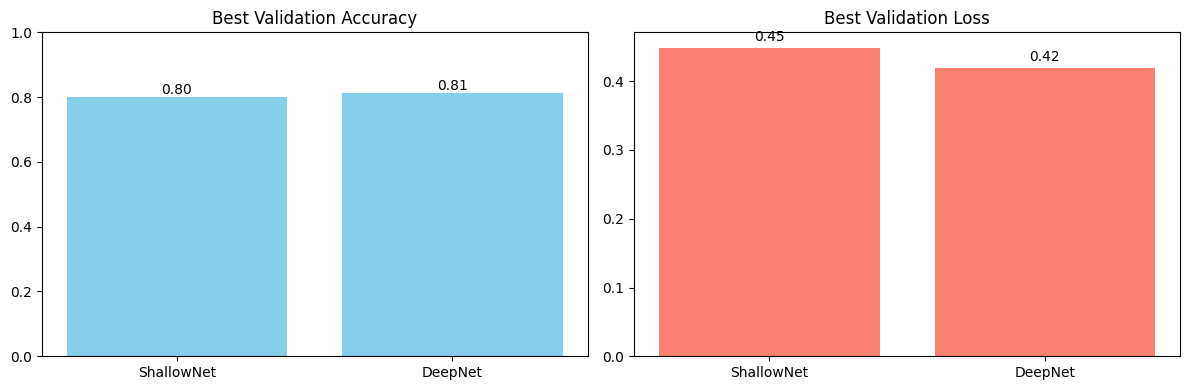

In [45]:
#Summarize Models
# 📊 Compare Models: Accuracy and Loss

def summarize_best_performance(model_names, histories):
    val_accuracies = []
    val_losses = []
    
    for history in histories:
        best_epoch = np.argmax(history.history['val_accuracy'])
        val_accuracies.append(history.history['val_accuracy'][best_epoch])
        val_losses.append(history.history['val_loss'][best_epoch])
    
    return model_names, val_accuracies, val_losses

def compare_models(model_names, accuracies, losses):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    axes[0].bar(model_names, accuracies, color='skyblue')
    axes[0].set_title("Best Validation Accuracy")
    axes[0].set_ylim(0, 1)
    for i, acc in enumerate(accuracies):
        axes[0].text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=10)

    # Loss
    axes[1].bar(model_names, losses, color='salmon')
    axes[1].set_title("Best Validation Loss")
    for i, loss in enumerate(losses):
        axes[1].text(i, loss + 0.01, f"{loss:.2f}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# Model names and histories
model_names = ['ShallowNet', 'DeepNet']
histories = [history1, history2]

# Summarize and plot
names, accs, losses = summarize_best_performance(model_names, histories)
compare_models(names, accs, losses)


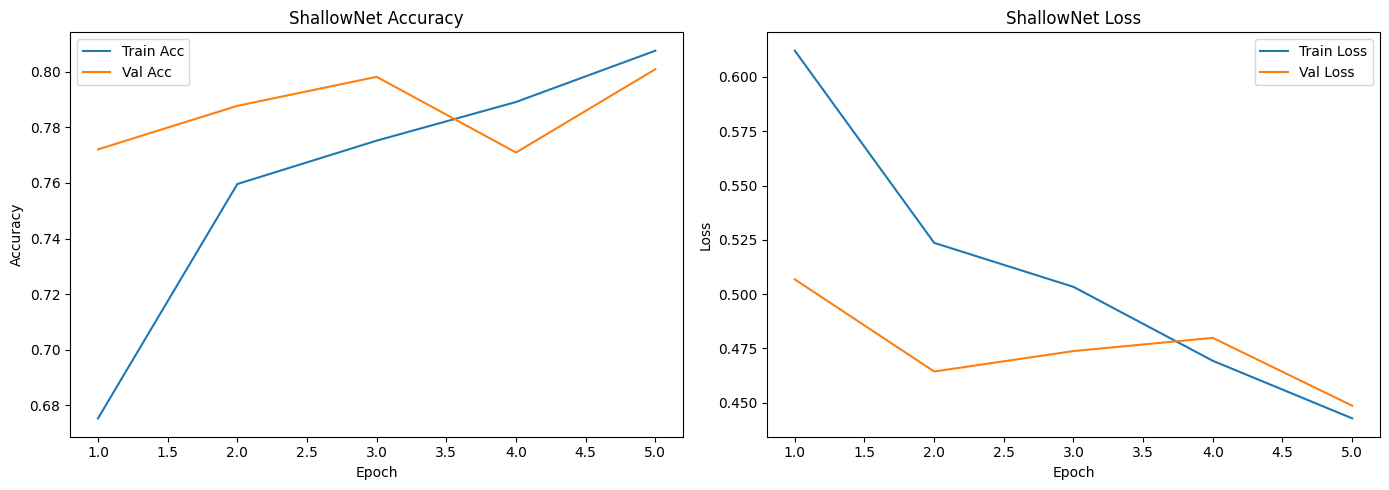

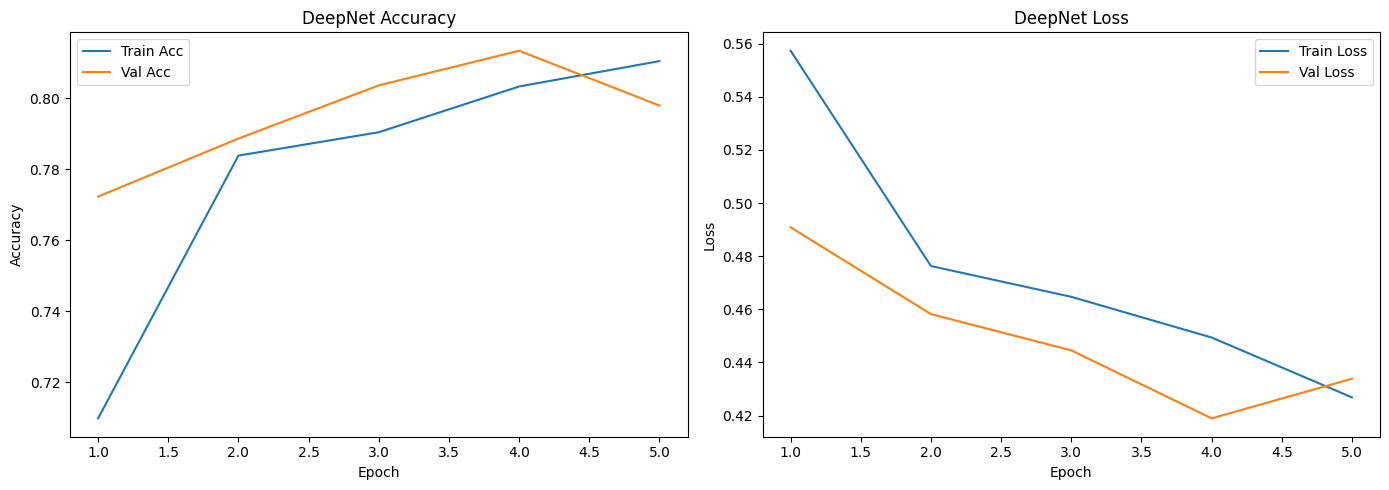

In [46]:
#Plot Training Curves
def plot_training_history(history, model_name):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Acc')
    plt.plot(epochs, history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for both models
plot_training_history(history1, "ShallowNet")
plot_training_history(history2, "DeepNet")


🏁 Model Comparison Summary
-----------------------------
ShallowNet ➤ Accuracy: 0.8010 | Loss: 0.4486
DeepNet ➤ Accuracy: 0.8135 | Loss: 0.4190

 Best Model:
   → DeepNet with Accuracy = 0.8135 and Loss = 0.4190


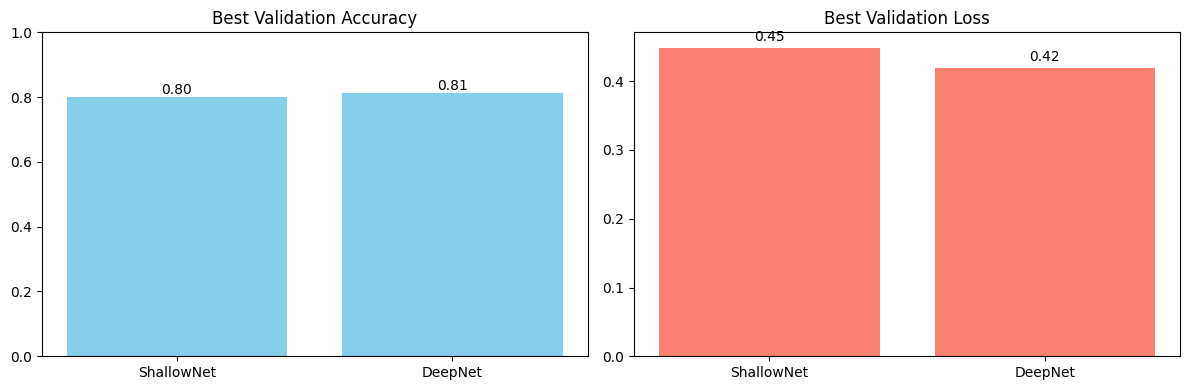

In [51]:
#Model Comparison Conclusion

# Summarize best validation metrics
model_names = ['ShallowNet', 'DeepNet']
histories = [history1, history2]

names, val_accuracies, val_losses = summarize_best_performance(model_names, histories)

# Identify the best model
best_index = np.argmax(val_accuracies)
best_model_name = names[best_index]
best_acc = val_accuracies[best_index]
best_loss = val_losses[best_index]

# Print conclusion
print("🏁 Model Comparison Summary")
print("-----------------------------")
for i in range(len(names)):
    print(f"{names[i]} ➤ Accuracy: {val_accuracies[i]:.4f} | Loss: {val_losses[i]:.4f}")
print("\n Best Model:")
print(f"   → {best_model_name} with Accuracy = {best_acc:.4f} and Loss = {best_loss:.4f}")

# Replot comparison for visual recap
compare_models(names, val_accuracies, val_losses)


In [ ]:
#Optimizing Models -OPTINAL-IT TOOK SO MUCH TIME TO RUN SO I DID NOT


import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Generate smaller subset of data (10% for speed)
df_train, df_val = generate_data(df, frac=0.1, test_size=0.2)

# Step 2: Create data generators
train_generator = create_train_generator(df_train)
val_generator = create_val_generator(df_val)

# Step 3: Create early stopping
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

# Step 4: Define Double Deep CNN with RMSprop
model_doubleDeep_RMSprop = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Step 5: Compile with RMSprop
model_doubleDeep_RMSprop.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Fit the model (no workers/multiprocessing)
history_doubleDeep_RMSprop = model_doubleDeep_RMSprop.fit(
    train_generator,
    epochs=5,  # Shorter for fast experimentation
    validation_data=val_generator,
    callbacks=[early_stopper],
    verbose=1
)


Conclusion
In this project, I assessed multiple convolutional neural network (CNN) architectures and strategies for histopathologic cancer detection using image data. My aim was to classify whether tissue images contained metastatic cancer accurately.

First, I began with a simple ShallowNet model to establish a baseline. Later, I progressively increased model complexity by introducing deeper architectures (DeepNet). The Double DeepNet achieved the best validation performance, demonstrating that deeper networks can better capture visual patterns important for tumor detection.

To further optimize performance, we experimented with different training techniques. We replaced the default Adam optimizer with RMSprop, which slightly improved training stability. Although training times increased due to larger model sizes and the dataset’s volume, our early stopping mechanism helped mitigate overfitting and unnecessary computation.

Overall, my findings revealed that deeper CNNs generally outperform shallow models in complex image classification tasks. The Double Deep CNN yielded the best overall performance in terms of validation accuracy and loss. My results underscore the importance of architectural design and training strategy in building effective deep learning models for medical image classification.

Reference
Kaggle. (2019). Histopathologic Cancer Detection Dataset – Accessed for image data and labels of metastatic cancer in lymph node sections.

Chollet, F. (2017). Deep Learning with Python. Manning Publications – Provided foundational knowledge on CNNs and Keras/TensorFlow implementation.

